In [4]:
# Clone the repo so Colab can access all the files, including utilities.py
!git clone https://github.com/PouyaRepos/sequential_anomaly_detection.git
%cd sequential_anomaly_detection


Cloning into 'sequential_anomaly_detection'...
remote: Enumerating objects: 18841, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (42/42), done.
Receiving objects: 100% (18841/18841), 118.83 MiB | 4.30 MiB/s, done.
remote: Total 18841 (delta 25), reused 35 (delta 14), pack-reused 18785 (from 2)
Resolving deltas: 100% (1676/1676), done.
/Users/pouyaabbasi/Documents/Projects/sequential_anomaly_detection/sequential_anomaly_detection


# Industrial Equipment Predictive Maintenance

In [1]:
from utilities import NoisyLearningAlgorithm
import itertools
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from pykalman import KalmanFilter
from scipy.fft import fft, ifft
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


/Users/pouyaabbasi/Documents/Projects/sequential_anomaly_detection/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
# Download dataset and import into Pandas DataFrame
path = kagglehub.dataset_download("mayurgadekar5555/industrial-equipment-maintenance-data")
print("Path to dataset files:", path)
file_path = f"{path}/data/raw/equipment_data.csv"
df = pd.read_csv(file_path)
df.head(25)
df.tail(25)
# print(df.info())

Path to dataset files: /Users/pouyaabbasi/.cache/kagglehub/datasets/mayurgadekar5555/industrial-equipment-maintenance-data/versions/1


,Timestamp,Temperature (°C),Vibration (mm/s),Pressure (Pa),RPM,Maintenance Required,Temp_Change,Vib_Change
43775,2023-12-29 23:00:00,0.925015,0.394493,0.617354,0.647765,0,0.725615,0.552976
43776,2023-12-30 00:00:00,0.425060,0.429628,0.595292,0.290193,0,0.249476,0.517251
43777,2023-12-30 01:00:00,0.313748,0.218520,0.626746,0.074049,0,0.445100,0.393673
43778,2023-12-30 02:00:00,0.447790,0.529440,0.396008,0.929286,1,0.568599,0.655656
43779,2023-12-30 03:00:00,0.192207,0.532148,0.830434,0.543029,1,0.372481,0.500978
43780,2023-12-30 04:00:00,0.702759,0.525420,0.883763,0.581721,0,0.758116,0.496242
43781,2023-12-30 05:00:00,0.890194,0.750439,0.413864,0.685123,0,0.595475,0.612546
43782,2023-12-30 06:00:00,0.059437,0.738483,0.035996,0.949967,1,0.082966,0.493619
43783,2023-12-30 07:00:00,0.676423,0.497660,0.320411,0.892595,0,0.811690,0.378759
43784,2023-12-30 08:00:00,0.333100,0.093815,0.741011,0.202802,0,0.328317,0.296946


# Sort by Timestamp and split to test/train

In [3]:
# Sorting the data by timestamp
df = df.sort_values('Timestamp')
feature_cols = ['Temperature (°C)', 'Vibration (mm/s)', 'Pressure (Pa)', 'RPM',
                'Temp_Change', 'Vib_Change']
label_col = "Maintenance Required"  # 1 if maintenance is required, 0 otherwise


# Train/test split 
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

X_train_raw = df_train[feature_cols].values
y_train_raw = df_train[label_col].values

X_test_raw = df_test[feature_cols].values
y_test_raw = df_test[label_col].values


# Preprocess

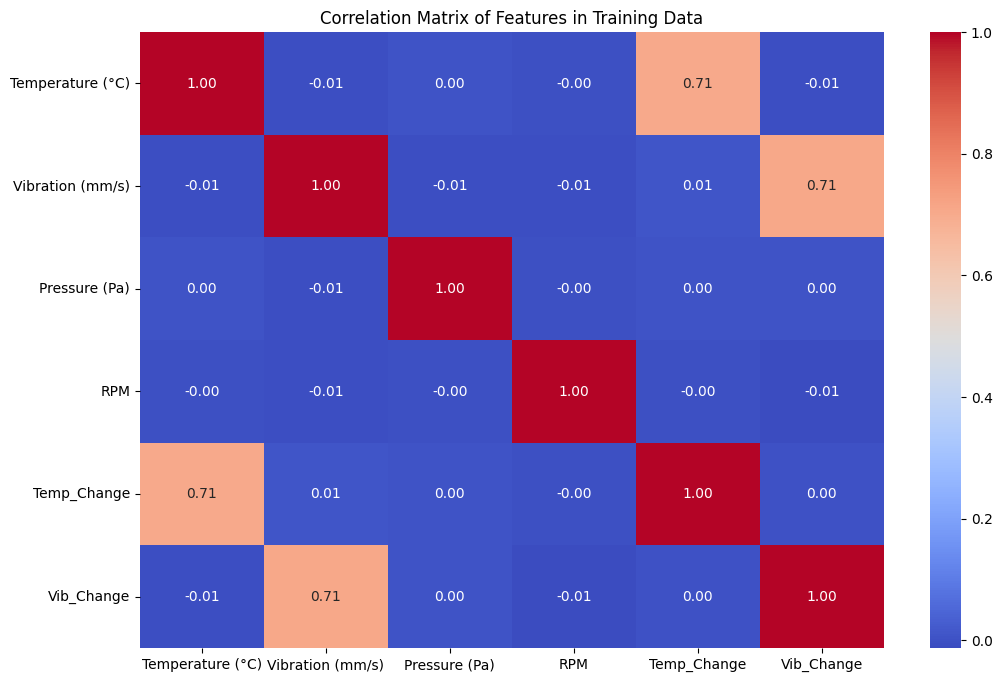

In [4]:
# Correlation matrix
correlation_matrix = df_train[feature_cols].corr()

#plot the matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features in Training Data")
plt.show()


Since the corraltions between Temp_change/Tempreature and Vib_change/Vibration are high, we remove Temp_change and Vib_change

## Fourier Transform

Check the link:
https://www.youtube.com/watch?v=s2K1JfNR7Sc&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC&index=20

In [ ]:
# Try the Fourier Transform

# Create a pipeline including Kalman, Fourier, Windowing, and MinMaxScaler

In [5]:


# --------------------------
# Custom Transformer: Kalman
# --------------------------
class KalmanSmoother(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        smoothed = np.zeros_like(X)
        for i in range(X.shape[1]):
            kf = KalmanFilter(initial_state_mean=X[0, i], n_dim_obs=1)
            state_means, _ = kf.smooth(X[:, i])
            smoothed[:, i] = state_means.ravel()  
        return smoothed

# --------------------------
# Custom Transformer: Fourier
# --------------------------
class FourierDeseasonalizer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5):
        self.n_components = n_components
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        cleaned = []
        for i in range(X.shape[1]):
            fft_vals = fft(X[:, i])
            fft_clean = np.zeros_like(fft_vals)
            fft_clean[:self.n_components] = fft_vals[:self.n_components]
            fft_clean[-self.n_components:] = fft_vals[-self.n_components:]
            seasonality = np.real(ifft(fft_clean))
            cleaned.append(X[:, i] - seasonality)
        return np.array(cleaned).T

# --------------------------
# Custom Transformer: Windowing
# --------------------------
class TimeSeriesWindowing(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=30, step_size=1):
        self.window_size = window_size
        self.step_size = step_size
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        windows = []
        for i in range(0, X.shape[0] - self.window_size + 1, self.step_size):
            window = X[i:i+self.window_size].flatten()
            windows.append(window)
        return np.array(windows)

# --------------------------
# Assemble the full pipeline
# --------------------------
def build_ts_pipeline(window_size=24, step_size=1, fourier_components=5): #, pca_components=5)
    return Pipeline([
        ('kalman', KalmanSmoother()),
        ('fourier', FourierDeseasonalizer(n_components=fourier_components)),
        ('window', TimeSeriesWindowing(window_size=window_size, step_size=step_size)),
        # ('pca', PCA(n_components=pca_components)),
        ('scaler',  MinMaxScaler(feature_range=(0, .9999999)))

    ])


# Plot features

In [6]:

pipeline = build_ts_pipeline(window_size=0, step_size=1, fourier_components=5) #, pca_components=5)
# Now you can step through the pipeline
X_kalman = pipeline.named_steps['kalman'].transform(X_train_raw)
X_fourier = pipeline.named_steps['fourier'].transform(X_kalman)
X_scaled = pipeline.named_steps['scaler'].fit_transform(X_fourier)

print(X_scaled.shape)



(35040, 6)


In [7]:
# Create a DataFrame from X_scaled
df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)
# Add the corresponding timestamp to df_scaled
df_scaled['Timestamp'] = df_train['Timestamp'].values[:df_scaled.shape[0]]
# Reorder columns to make 'Timestamp' the first column
cols = ['Timestamp'] + [col for col in df_scaled.columns if col != 'Timestamp']
df_scaled = df_scaled[cols]
df_scaled.head()


,Timestamp,Temperature (°C),Vibration (mm/s),Pressure (Pa),RPM,Temp_Change,Vib_Change
0,2019-01-01 00:00:00,0.587417,0.511230,0.683389,0.699072,0.526964,0.493399
1,2019-01-01 01:00:00,0.649924,0.504201,0.779774,0.534179,0.572066,0.488690
2,2019-01-01 02:00:00,0.610494,0.391942,0.799259,0.658819,0.456348,0.374310
3,2019-01-01 03:00:00,0.561940,0.419227,0.562677,0.800571,0.446953,0.525400
4,2019-01-01 04:00:00,0.523792,0.362921,0.375084,0.732888,0.459581,0.434764


In [11]:
# Convert 'Timestamp' to datetime format
df_scaled['Timestamp'] = pd.to_datetime(df_scaled['Timestamp'])

# Filter rows where the year is 2019
df_scaled_2019 = df_scaled[df_scaled['Timestamp'].dt.year == 2019]
print(df_scaled_2019.shape)
df_scaled_2019.head()


(8760, 7)


,Timestamp,Temperature (°C),Vibration (mm/s),Pressure (Pa),RPM,Temp_Change,Vib_Change
0,2019-01-01 00:00:00,0.587417,0.511230,0.683389,0.699072,0.526964,0.493399
1,2019-01-01 01:00:00,0.649924,0.504201,0.779774,0.534179,0.572066,0.488690
2,2019-01-01 02:00:00,0.610494,0.391942,0.799259,0.658819,0.456348,0.374310
3,2019-01-01 03:00:00,0.561940,0.419227,0.562677,0.800571,0.446953,0.525400
4,2019-01-01 04:00:00,0.523792,0.362921,0.375084,0.732888,0.459581,0.434764


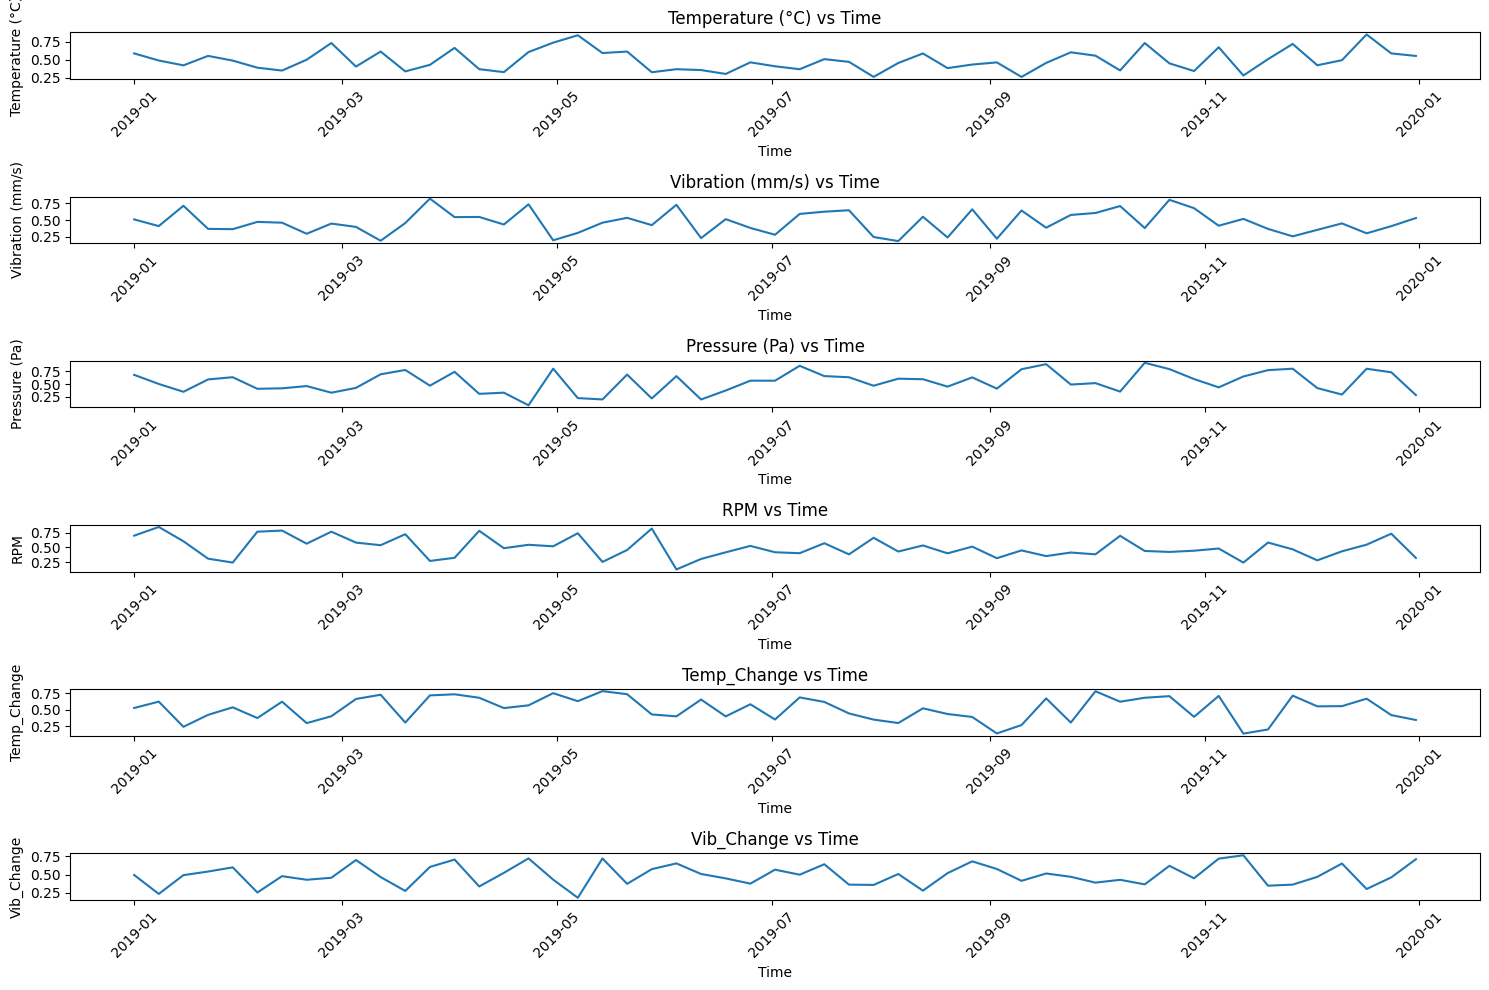

In [14]:

plt.figure(figsize=(15, 10))  # Adjust size to fit all plots

# Loop through features and plot each one
for i, feature in enumerate(feature_cols):
    plt.subplot(len(feature_cols), 1, i + 1)
    plt.plot(df_scaled_2019['Timestamp'][::168], df_scaled_2019[feature][::168], label=feature)
    plt.title(f'{feature} vs Time')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.grid(False)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Create a DataFrame from X_scaled
df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)
# Add the corresponding timestamp to df_scaled
df_scaled['Timestamp'] = df_train['Timestamp'].values[:df_scaled.shape[0]]
# Reorder columns to make 'Timestamp' the first column
cols = ['Timestamp'] + [col for col in df_scaled.columns if col != 'Timestamp']
df_scaled = df_scaled[cols]
df_scaled.head()

# Plot each feature vs time
plt.figure(figsize=(15, 10))

for i, feature in enumerate(feature_cols):
    plt.subplot(len(feature_cols), 1, i + 1)
    plt.plot(df_scaled['Timestamp'], df_scaled[feature])
    plt.title(f'{feature} vs Time')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

# Applying pipeline and PCA

In [102]:

window_size =1 # 7 hours 24 # 24 hours

pipeline = build_ts_pipeline(window_size=window_size, step_size=1, fourier_components=5) #, pca_components=5)

# Step 1: Fit-transform training data
pipeline.fit(X_train_raw)
X_train_transformed = pipeline.transform(X_train_raw)

# Step 2: Apply same pipeline to test data
X_test_transformed = pipeline.transform(X_test_raw)

# Step 3: Fit PCA on training transformed windows only
n_components = X_train_transformed.shape[1] # 24 * 6 = 144
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

# Step 4: Align labels
y_train_aligned = y_train_raw[window_size - 1:]
y_test_aligned = y_test_raw[window_size - 1:]

# Check
assert X_train_pca.shape[0] == y_train_aligned.shape[0]
assert X_test_pca.shape[0] == y_test_aligned.shape[0]


Shape after PCA: (35040, 6)
Explained variance by each component: [0.23019472 0.22584474 0.18151444 0.17489545 0.09561965 0.091931  ]
Sum of explained variances: 1.0


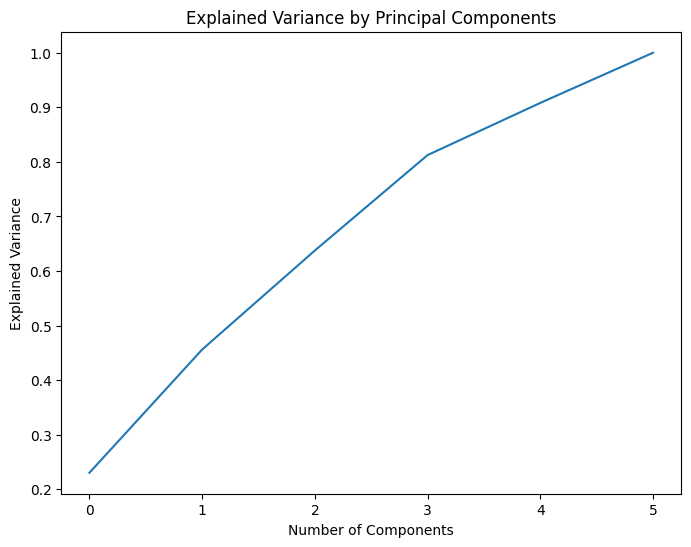

In [103]:
# Print shapes and explained variance
print("Shape after PCA:", X_train_pca.shape)
print(f"Explained variance by each component: {pca.explained_variance_ratio_[:10]}")
print(f"Sum of explained variances: {sum(pca.explained_variance_ratio_)}")

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

# Reduce  feature dimensions from 140 to 80.  It explains almost 90% of variances.

In [104]:
pca = PCA(n_components=X_train_transformed.shape[1])
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

scaler_post_pca = MinMaxScaler()
X_train_scaled = scaler_post_pca.fit_transform(X_train_pca)
X_test_scaled = scaler_post_pca.transform(X_test_pca)
X_train_scaled.shape, X_test_scaled.shape

((35040, 6), (8760, 6))

# Try model

No more active cells. Breaking out of the loop.
Feature dimension 6 is not supported for visualization.
Model: NoisyLearningAlgorithm
Mean Accuracy: 0.7725
Mean AUC-ROC: 0.7725
report:                       0             1  accuracy     macro avg  weighted avg
precision      0.774095      0.770851   0.77246      0.772473      0.772471
recall         0.768743      0.776169   0.77246      0.772456      0.772460
f1-score       0.771410      0.773501   0.77246      0.772455      0.772456
support    17500.000000  17540.000000   0.77246  35040.000000  35040.000000


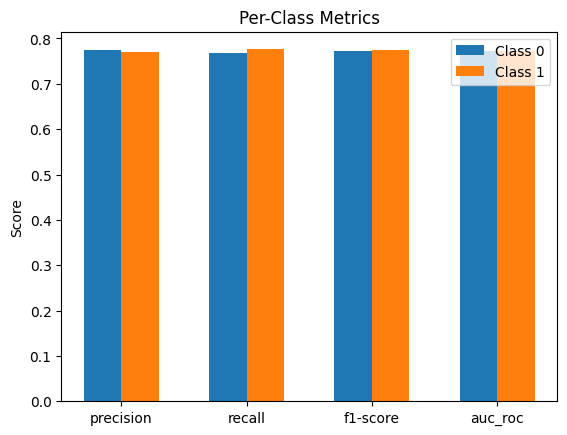

----------------------------------------------------------------------------------------------------
Feature dimension 6 is not supported for visualization.
Model: NoisyLearningAlgorithm
Mean Accuracy: 0.5064
Mean AUC-ROC: 0.5069
report:                      0            1  accuracy    macro avg  weighted avg
precision     0.503710     0.511290  0.506393     0.507500      0.507512
recall        0.653000     0.360719  0.506393     0.506860      0.506393
f1-score      0.568721     0.423005  0.506393     0.495863      0.495630
support    4366.000000  4394.000000  0.506393  8760.000000   8760.000000


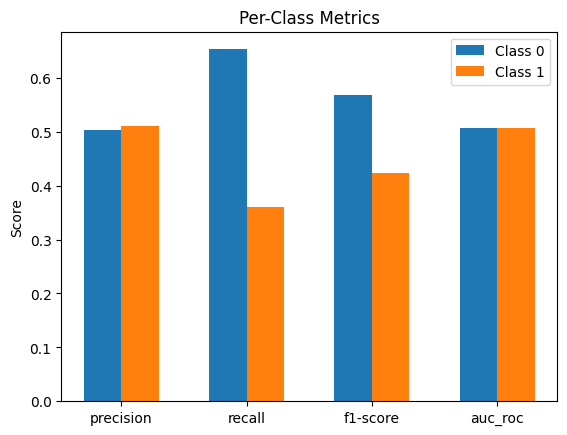

----------------------------------------------------------------------------------------------------


In [112]:
# Parameters
n_budget = 100 # Query budget
feature_dimension = X_train_scaled.shape[1] # for feature_dimension = 2 and 3, it plots the 2D or #d dyadic grid

#--------------------------
# Train model
#--------------------------
algo = NoisyLearningAlgorithm(n_budget=n_budget, delta=0.05, alpha=0.01, lambda_=10, feature_dimension= feature_dimension, B_l_alpha= .01, initial_depth_level= 3)
s0, s1, ac, results= algo.run(X_train_scaled, y_train_aligned)

# --------------------------
# Traing data evaluation
# --------------------------
# Plot the dyadic grid. It will plot only for 2D or 3D feature_dimension
algo.plot_dyadic_grid(X_train_scaled,y_train_aligned)

# Evaluate the model on the training set
algo.evaluate_model(X_train_scaled, y_train_aligned)

#--------------------------
# Test data evaluation
#--------------------------
# Plot the dyadic grid. It will plot only for 2D or 3D feature_dimension
algo.plot_dyadic_grid(X_test_scaled,y_test_aligned)

# Evaluate the model on the test set
algo.evaluate_model(X_test_scaled, y_test_aligned)